# Model S profiles

__José Roberto Canivete Cuissa__  
__19.01.2023, Zurich__

---------

This Notebook contains the analysis and routines to generate a "Model S"-like profile for RAMSES simulations of magnetoconvection

----------
 
## Imports and constants

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const

# Files
gong_file = 'data/fgong.l5bi.d.15'
modelS_file = 'data/cptrho.l5bi.d.15c'

------

## Read and plot Model S main quantities 

In [2]:
def read_modelS(modelS_file):
    """ Routine reading the modelS simplified file """
    # Open file
    f = open(modelS_file, 'r')
    lines = f.readlines()
    f.close()
    
    # Discard header and prepare lists of quantities
    lines = lines[6:]
    r = []          # Radius
    c = []          # Sound speed
    d = []        # Density
    p = []          # Pressure
    gamma_1 = []    # First adiabatic index
    T = []          # Temperature
    
    # Read quantities in lines
    for i in lines:
        columns = i.split()
        r.append(float(columns[0]))
        c.append(float(columns[1]))
        d.append(float(columns[2]))
        p.append(float(columns[3]))
        gamma_1.append(float(columns[4]))
        T.append(float(columns[5]))
    # Save as a dictionary
    modelS = {'r':np.array(r),
              'c':np.array(c),
              'd':np.array(d),
              'p':np.array(p),
              'gamma_1':np.array(gamma_1),
              'T':np.array(T)}
    
    # Add entropy
    gamma = 5./3.
    s = modelS['p']/(modelS['d']**gamma)
    modelS['s']=s
    modelS = grav_acc(modelS)
    return modelS

def grav_acc(modelS):
    """ Compute gravitational acceleration """
    # gather variables in cgs
    r_cm = modelS['r'][::-1]*const.R_sun.to('cm').value
    d = modelS['d'][::-1]
    dr = r_cm[1:]-r_cm[:-1]
    
    # Integrate
    g = [0.]
    integral = 0.
    for i in np.arange(dr.shape[0]):
        G = const.G.value*1e3 # cm³/g/s²
        integral += 4.*np.pi*dr[i]*(r_cm[i]**2)*d[i]
        g.append(integral*const.G.to('cm3/(g s2)').value/(r_cm[i]**2))
    g=np.array(g)
    modelS['g'] = g[::-1]
    return modelS

/sctmp/jcaniv/ipykernel_1541609/4076549324.py:54: RuntimeWarning: invalid value encountered in double_scalars
  g.append(integral*const.G.to('cm3/(g s2)').value/(r_cm[i]**2))


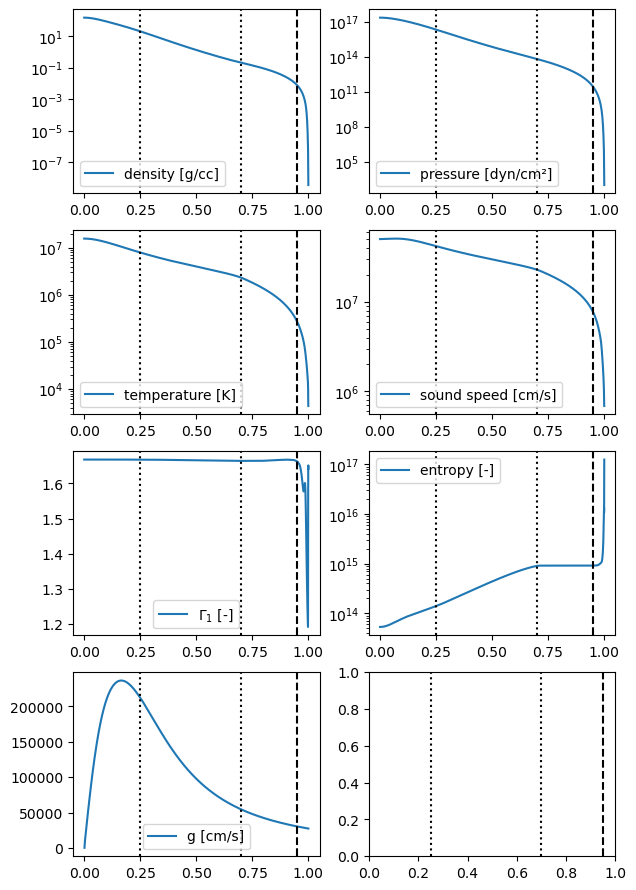

In [3]:
# Read file
modelS = read_modelS(modelS_file)

# Prepare figure
fig, axes = plt.subplots(4,2,figsize=(7,11))

# Plot density
ax = axes[0,0]
ax.plot(modelS['r'], modelS['d'], label='density [g/cc]')
ax.set_yscale('log')
ax.legend()

# Plot pressure
ax = axes[0,1]
ax.plot(modelS['r'], modelS['p'], label='pressure [dyn/cm²]')
ax.set_yscale('log')
ax.legend()

# Plot temperature
ax = axes[1,0]
ax.plot(modelS['r'], modelS['T'], label='temperature [K]')
ax.set_yscale('log')
ax.legend()

# Plot sound speed
ax = axes[1,1]
ax.plot(modelS['r'], modelS['c'], label='sound speed [cm/s]')
ax.set_yscale('log')
ax.legend()

# Plot adiabatic index
ax = axes[2,0]
ax.plot(modelS['r'], modelS['gamma_1'], label=r'$\Gamma_1$ [-]')
ax.legend()

# Plot entropy
ax = axes[2,1]
ax.plot(modelS['r'], modelS['s'], label=r'entropy [-]')
ax.set_yscale('log')
ax.legend()

# Plot g
ax = axes[3,0]
ax.plot(modelS['r'], modelS['g'], label=r'g [cm/s]')
ax.legend()

# Boundaries of convection zone
for ax in axes.ravel():
    ax.axvline(0.25, color='k', linestyle=':')
    ax.axvline(0.7, color='k', linestyle=':')
    ax.axvline(0.95, color='k', linestyle='--')

-----------

## Generate politropic profiles that "match" the model S ones

In [4]:
def polytrope(ri, rf, gamma, g, di, pi, orientation='forwards'):
    """ Polytrope in hydrostatic equilibrium given density and pressure in r_i """
    # Constants
    k_B = const.k_B.to('erg/K').value
    m_p = const.m_p.to('g').value
    # Radial range
    r = np.linspace(ri,rf,201)
    if orientation=='backwards':
        r = r[::-1]
    # Formulas
    d = di*(1.0 - ((gamma-1.0)/gamma)*g*(di/pi)*(r-ri)*const.R_sun.to('cm').value)**(1.0/(gamma-1.0))
    p = pi*(d/di)**(gamma)
    # Derived quantities T and s
    T = p*m_p/(k_B*d)
    s = p/(d**(5./3.))
    c = np.sqrt((5./3.)*p/d)
    profile = {'r':r,
               'd':d,
               'p':p,
               'T':T,
               's':s,
               'c':c,
               'gamma':gamma,
               'g':g,
               'di':d[0],
               'pi':p[0]}
    if orientation=='backwards':
        profile['ri'] = rf
        profile['rf'] = ri
    elif orientation=='forwards':
        profile['ri'] = ri
        profile['rf'] = rf

    return profile

def find_value(model, var_name, radius):
    """ Returns the value of the quantity at a certain radius """
    var = model[var_name]
    r = model['r']
    dr = np.abs(r - radius)
    index = np.argsort(dr)[0]
    return var[index], index

### Convection zone

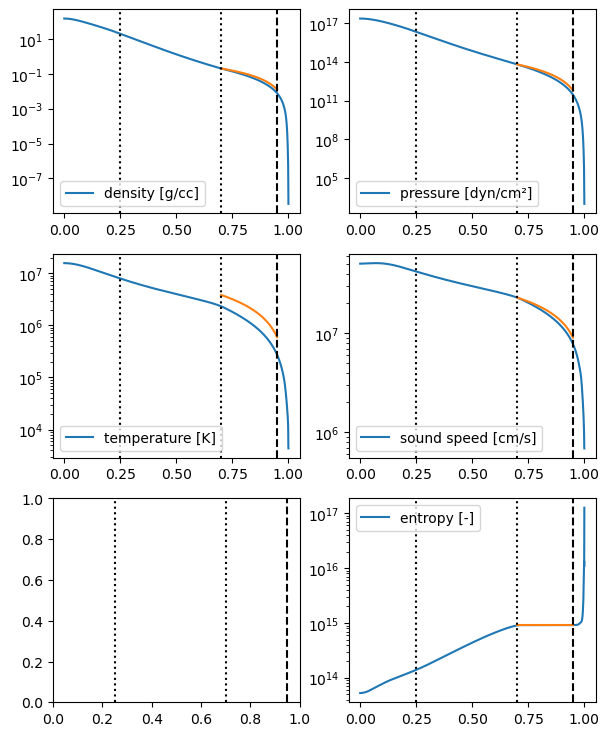

In [5]:
# Set boundaries of region
ri_conv = 0.70
rf_conv = 0.95
# Get i values and indices
di, idxi = find_value(modelS, 'd', ri_conv)
pi, _    = find_value(modelS, 'p', ri_conv)
_ , idxf = find_value(modelS, 'd', rf_conv)
gamma_conv = 5./3.
# Compute average grav. acc.
g_conv = np.mean(modelS['g'][idxf:idxi])

# Define initial values
di_conv = di*1.0
pi_conv = pi*1.0

# Get profile
profile_conv = polytrope(ri_conv, rf_conv, gamma_conv, g_conv, di_conv, pi_conv)

# Prepare figure
fig, axes = plt.subplots(3,2,figsize=(7,9))
# Plot density
ax = axes[0,0]
ax.plot(modelS['r'], modelS['d'], label='density [g/cc]')
ax.plot(profile_conv['r'], profile_conv['d'])
ax.set_yscale('log')
ax.legend()

# Plot pressure
ax = axes[0,1]
ax.plot(modelS['r'], modelS['p'], label='pressure [dyn/cm²]')
ax.plot(profile_conv['r'], profile_conv['p'])
ax.set_yscale('log')
ax.legend()

# Plot temperature
ax = axes[1,0]
ax.plot(modelS['r'], modelS['T'], label='temperature [K]')
ax.plot(profile_conv['r'], profile_conv['T'])
ax.set_yscale('log')
ax.legend()

# Plot sound speed
ax = axes[1,1]
ax.plot(modelS['r'], modelS['c'], label='sound speed [cm/s]')
ax.plot(profile_conv['r'], profile_conv['c'])
ax.set_yscale('log')
ax.legend()

# Plot entropy
ax = axes[2,1]
ax.plot(modelS['r'], modelS['s'], label=r'entropy [-]')
ax.plot(profile_conv['r'], profile_conv['s'])
ax.set_yscale('log')
ax.legend()


# Boundaries of convection zone
for ax in axes.ravel():
    ax.axvline(0.25, color='k', linestyle=':')
    ax.axvline(0.7, color='k', linestyle=':')
    ax.axvline(0.95, color='k', linestyle='--')

### Radiative Zone

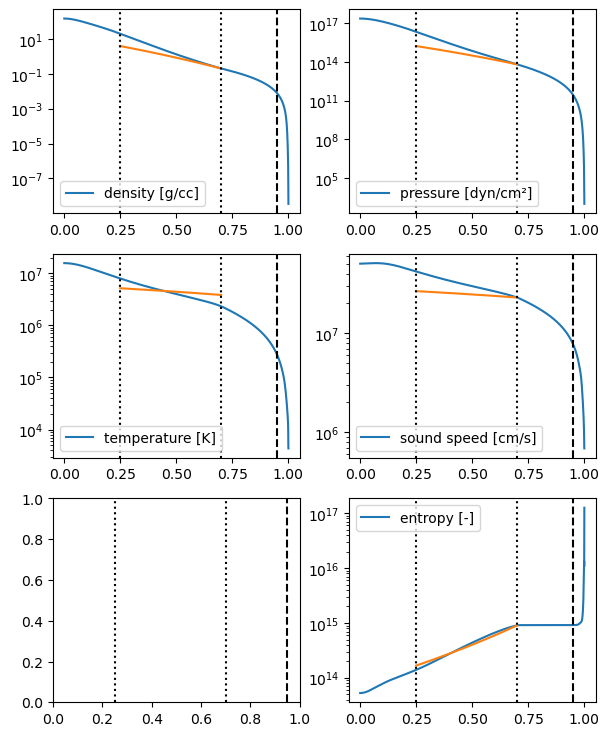

In [6]:
# Set boundaries of region
ri_rad = ri_conv
rf_rad = 0.25
# Get i values and indices
di, idxi = find_value(modelS, 'd', ri_rad)
pi, _    = find_value(modelS, 'p', ri_rad)
_ , idxf = find_value(modelS, 'd', rf_rad)
gamma_rad = 1.1
# Compute average grav. acc.
g_rad = g_conv

# Define initial values
di_rad = di_conv
pi_rad = pi_conv

# Get profile
profile_rad = polytrope(ri_rad, rf_rad, gamma_rad, g_rad, di_rad, pi_rad, orientation='backwards')

# Prepare figure
fig, axes = plt.subplots(3,2,figsize=(7,9))
# Plot density
ax = axes[0,0]
ax.plot(modelS['r'], modelS['d'], label='density [g/cc]')
ax.plot(profile_rad['r'], profile_rad['d'])
ax.set_yscale('log')
ax.legend()

# Plot pressure
ax = axes[0,1]
ax.plot(modelS['r'], modelS['p'], label='pressure [dyn/cm²]')
ax.plot(profile_rad['r'], profile_rad['p'])
ax.set_yscale('log')
ax.legend()

# Plot temperature
ax = axes[1,0]
ax.plot(modelS['r'], modelS['T'], label='temperature [K]')
ax.plot(profile_rad['r'], profile_rad['T'])
ax.set_yscale('log')
ax.legend()

# Plot sound speed
ax = axes[1,1]
ax.plot(modelS['r'], modelS['c'], label='sound speed [cm/s]')
ax.plot(profile_rad['r'], profile_rad['c'])
ax.set_yscale('log')
ax.legend()

# Plot entropy
ax = axes[2,1]
ax.plot(modelS['r'], modelS['s'], label=r'entropy [-]')
ax.plot(profile_rad['r'], profile_rad['s'])
ax.set_yscale('log')
ax.legend()


# Boundaries of convection zone
for ax in axes.ravel():
    ax.axvline(0.25, color='k', linestyle=':')
    ax.axvline(0.7, color='k', linestyle=':')
    ax.axvline(0.95, color='k', linestyle='--')

### Core

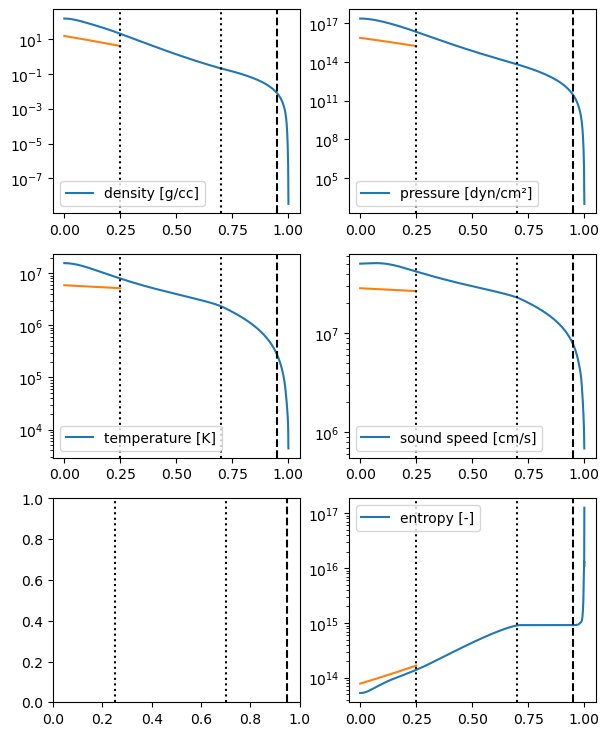

In [7]:
# Set boundaries of region
ri_core = rf_rad
rf_core = 0.0
# Get i values and indices
di, idxi = find_value(modelS, 'd', ri_core)
pi, _    = find_value(modelS, 'p', ri_core)
_ , idxf = find_value(modelS, 'd', rf_core)
gamma_core = 1.1
# Compute average grav. acc.
g_core = g_conv

# Define initial values
di_core = profile_rad['d'][0]
pi_core = profile_rad['p'][0]

# Get profile
profile_core = polytrope(ri_core, rf_core, gamma_core, g_core, di_core, pi_core, orientation='backwards')

# Prepare figure
fig, axes = plt.subplots(3,2,figsize=(7,9))
# Plot density
ax = axes[0,0]
ax.plot(modelS['r'], modelS['d'], label='density [g/cc]')
ax.plot(profile_core['r'], profile_core['d'])
ax.set_yscale('log')
ax.legend()

# Plot pressure
ax = axes[0,1]
ax.plot(modelS['r'], modelS['p'], label='pressure [dyn/cm²]')
ax.plot(profile_core['r'], profile_core['p'])
ax.set_yscale('log')
ax.legend()

# Plot temperature
ax = axes[1,0]
ax.plot(modelS['r'], modelS['T'], label='temperature [K]')
ax.plot(profile_core['r'], profile_core['T'])
ax.set_yscale('log')
ax.legend()

# Plot sound speed
ax = axes[1,1]
ax.plot(modelS['r'], modelS['c'], label='sound speed [cm/s]')
ax.plot(profile_core['r'], profile_core['c'])
ax.set_yscale('log')
ax.legend()

# Plot entropy
ax = axes[2,1]
ax.plot(modelS['r'], modelS['s'], label=r'entropy [-]')
ax.plot(profile_core['r'], profile_core['s'])
ax.set_yscale('log')
ax.legend()


# Boundaries of convection zone
for ax in axes.ravel():
    ax.axvline(0.25, color='k', linestyle=':')
    ax.axvline(0.7, color='k', linestyle=':')
    ax.axvline(0.95, color='k', linestyle='--')

### "Atmosphere"

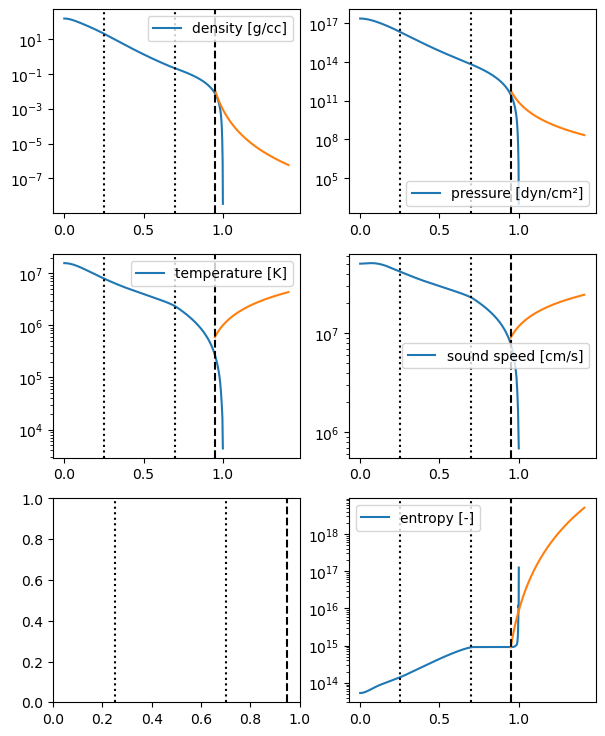

In [8]:
# Set boundaries of region
ri_atm = rf_conv
rf_atm = np.sqrt(2.0)
# Get i values and indices
di, idxi = find_value(modelS, 'd', ri_atm)
pi, _    = find_value(modelS, 'p', ri_atm)
_ , idxf = find_value(modelS, 'd', rf_atm)
gamma_atm = 0.8
# Compute average grav. acc.
g_atm = g_conv

# Define initial values
di_atm = profile_conv['d'][-1]
pi_atm = profile_conv['p'][-1]

# Get profile
profile_atm = polytrope(ri_atm, rf_atm, gamma_atm, g_atm, di_atm, pi_atm)

# Prepare figure
fig, axes = plt.subplots(3,2,figsize=(7,9))
# Plot density
ax = axes[0,0]
ax.plot(modelS['r'], modelS['d'], label='density [g/cc]')
ax.plot(profile_atm['r'], profile_atm['d'])
ax.set_yscale('log')
ax.legend()

# Plot pressure
ax = axes[0,1]
ax.plot(modelS['r'], modelS['p'], label='pressure [dyn/cm²]')
ax.plot(profile_atm['r'], profile_atm['p'])
ax.set_yscale('log')
ax.legend()

# Plot temperature
ax = axes[1,0]
ax.plot(modelS['r'], modelS['T'], label='temperature [K]')
ax.plot(profile_atm['r'], profile_atm['T'])
ax.set_yscale('log')
ax.legend()

# Plot sound speed
ax = axes[1,1]
ax.plot(modelS['r'], modelS['c'], label='sound speed [cm/s]')
ax.plot(profile_atm['r'], profile_atm['c'])
ax.set_yscale('log')
ax.legend()

# Plot entropy
ax = axes[2,1]
ax.plot(modelS['r'], modelS['s'], label=r'entropy [-]')
ax.plot(profile_atm['r'], profile_atm['s'])
ax.set_yscale('log')
ax.legend()


# Boundaries of convection zone
for ax in axes.ravel():
    ax.axvline(0.25, color='k', linestyle=':')
    ax.axvline(0.7, color='k', linestyle=':')
    ax.axvline(0.95, color='k', linestyle='--')

### All togheter

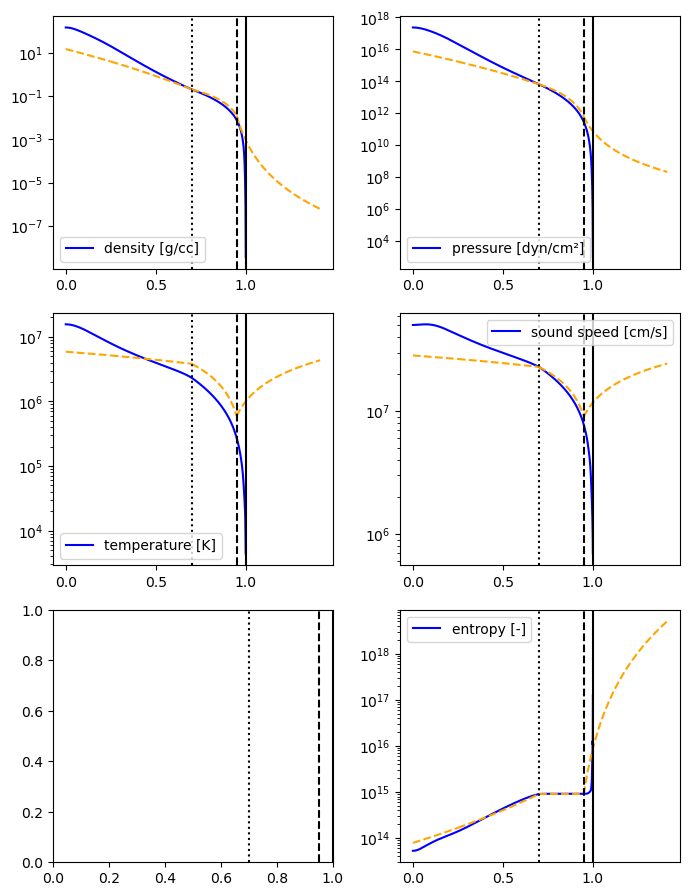

In [9]:
#Prepare figure
fig, axes = plt.subplots(3,2,figsize=(7,9))
# Plot density
ax = axes[0,0]
ax.plot(modelS['r'], modelS['d'], label='density [g/cc]', color='b')
ax.plot(profile_core['r'], profile_core['d'], color='orange', linestyle='--')
ax.plot(profile_rad['r'] , profile_rad['d'] , color='orange', linestyle='--')
ax.plot(profile_conv['r'], profile_conv['d'], color='orange', linestyle='--')
ax.plot(profile_atm['r'] , profile_atm['d'] , color='orange', linestyle='--')
ax.set_yscale('log')
ax.legend()

# Plot pressure
ax = axes[0,1]
ax.plot(modelS['r'], modelS['p'], label='pressure [dyn/cm²]', color='b')
ax.plot(profile_core['r'], profile_core['p'], color='orange', linestyle='--')
ax.plot(profile_rad['r'] , profile_rad['p'] , color='orange', linestyle='--')
ax.plot(profile_conv['r'], profile_conv['p'], color='orange', linestyle='--')
ax.plot(profile_atm['r'] , profile_atm['p'] , color='orange', linestyle='--')
ax.set_yscale('log')
ax.legend()

# Plot temperature
ax = axes[1,0]
ax.plot(modelS['r'], modelS['T'], label='temperature [K]', color='b')
ax.plot(profile_core['r'], profile_core['T'], color='orange', linestyle='--')
ax.plot(profile_rad['r'] , profile_rad['T'] , color='orange', linestyle='--')
ax.plot(profile_conv['r'], profile_conv['T'], color='orange', linestyle='--')
ax.plot(profile_atm['r'] , profile_atm['T'] , color='orange', linestyle='--')
ax.set_yscale('log')
ax.legend()

# Plot sound speed
ax = axes[1,1]
ax.plot(modelS['r'], modelS['c'], label='sound speed [cm/s]', color='b')
ax.plot(profile_core['r'], profile_core['c'], color='orange', linestyle='--')
ax.plot(profile_rad['r'] , profile_rad['c'] , color='orange', linestyle='--')
ax.plot(profile_conv['r'], profile_conv['c'], color='orange', linestyle='--')
ax.plot(profile_atm['r'] , profile_atm['c'] , color='orange', linestyle='--')
ax.set_yscale('log')
ax.legend()

# Plot entropy
ax = axes[2,1]
ax.plot(modelS['r'], modelS['s'], label=r'entropy [-]', color='b')
ax.plot(profile_core['r'], profile_core['s'], color='orange', linestyle='--')
ax.plot(profile_rad['r'] , profile_rad['s'] , color='orange', linestyle='--')
ax.plot(profile_conv['r'], profile_conv['s'], color='orange', linestyle='--')
ax.plot(profile_atm['r'] , profile_atm['s'] , color='orange', linestyle='--')
ax.set_yscale('log')
ax.legend()


# Boundaries of convection zone
for ax in axes.ravel():
    #ax.axvline(0.25, color='k', linestyle=':')
    ax.axvline(0.7, color='k', linestyle=':')
    ax.axvline(0.95, color='k', linestyle='--')
    ax.axvline(1.0, color='k', linestyle='-')

fig.tight_layout()
fig.savefig('modelS_profiles_theory.png', dpi=200)


### Print info for building profiles in RAMSES

In [10]:
# Core
print('+++++++ CORE ++++++++')
print(' di    = ', '{:.5E}'.format(profile_core['di']), 'g/cc')
print(' pi    = ', '{:.5E}'.format(profile_core['pi']*1e-16), ' x 10^16 dyn/cm²')
print(' ri    = ', '{:.5E}'.format(profile_core['ri']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' rf    = ', '{:.5E}'.format(profile_core['rf']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' gamma = ', profile_core['gamma'])
print(' g     = ', '{:.5E}'.format(profile_core['g']*1e-8), 'x 10^8 cm/s^2')

# Radiative zone
print('+++++++ RAD ++++++++')
print(' di    = ', '{:.5E}'.format(profile_rad['di']), 'g/cc')
print(' pi    = ', '{:.5E}'.format(profile_rad['pi']*1e-16), ' x 10^16 dyn/cm²')
print(' ri    = ', '{:.5E}'.format(profile_rad['ri']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' rf    = ', '{:.5E}'.format(profile_rad['rf']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' gamma = ', profile_rad['gamma'])
print(' g     = ', '{:.5E}'.format(profile_rad['g']*1e-8), 'x 10^8 cm/s^2')

# Convection zone
print('+++++++ CONV ++++++++')
print(' di    = ', '{:.5E}'.format(profile_conv['di']), 'g/cc')
print(' pi    = ', '{:.5E}'.format(profile_conv['pi']*1e-16), ' x 10^16 dyn/cm²')
print(' ri    = ', '{:.5E}'.format(profile_conv['ri']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' rf    = ', '{:.5E}'.format(profile_conv['rf']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' gamma = ', profile_conv['gamma'])
print(' g     = ', '{:.5E}'.format(profile_conv['g']*1e-8), 'x 10^8 cm/s^2')

# Atmosphere
print('+++++++ ATM ++++++++')
print(' di    = ', '{:.5E}'.format(profile_atm['di']), 'g/cc')
print(' pi    = ', '{:.5E}'.format(profile_atm['pi']*1e-16), ' x 10^16 dyn/cm²')
print(' ri    = ', '{:.5E}'.format(profile_atm['ri']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' rf    = ', '{:.5E}'.format(profile_atm['rf']*const.R_sun.to('cm').value/1e8), ' Mm')
print(' gamma = ', profile_atm['gamma'])
print(' g     = ', '{:.5E}'.format(profile_atm['g']*1e-8), 'x 10^8 cm/s^2')

# Other stuff
print('++++++++++++++++++++')
print('boxlen = ', '{:.5E}'.format(profile_atm['rf']/np.sqrt(2)*const.R_sun.to('cm').value*2.0/1e8), ' Mm')
print('center = ', '{:.5E}'.format(profile_atm['rf']/np.sqrt(2)*const.R_sun.to('cm').value/1e8), ' Mm')

+++++++ CORE ++++++++
 di    =  1.53865E+01 g/cc
 pi    =  7.49395E-01  x 10^16 dyn/cm²
 ri    =  0.00000E+00  Mm
 rf    =  1.73925E+02  Mm
 gamma =  1.1
 g     =  3.84779E-04 x 10^8 cm/s^2
+++++++ RAD ++++++++
 di    =  4.05182E+00 g/cc
 pi    =  1.72692E-01  x 10^16 dyn/cm²
 ri    =  1.73925E+02  Mm
 rf    =  4.86990E+02  Mm
 gamma =  1.1
 g     =  3.84779E-04 x 10^8 cm/s^2
+++++++ CONV ++++++++
 di    =  2.07918E-01 g/cc
 pi    =  6.58475E-03  x 10^16 dyn/cm²
 ri    =  4.86990E+02  Mm
 rf    =  6.60915E+02  Mm
 gamma =  1.6666666666666667
 g     =  3.84779E-04 x 10^8 cm/s^2
+++++++ ATM ++++++++
 di    =  1.26569E-02 g/cc
 pi    =  6.20293E-05  x 10^16 dyn/cm²
 ri    =  6.60915E+02  Mm
 rf    =  9.83868E+02  Mm
 gamma =  0.8
 g     =  3.84779E-04 x 10^8 cm/s^2
++++++++++++++++++++
boxlen =  1.39140E+03  Mm
center =  6.95700E+02  Mm


## Create and save full profiles

In [11]:
variables = ['r', 'd', 'p', 's', 'T']
full_profiles = []
for v in variables:
    profile = np.concatenate([profile_core[v], profile_rad[v], profile_conv[v], profile_atm[v]]) 
    full_profiles.append(profile)
full_profiles = np.array(full_profiles)
full_profiles.shape
np.save('modelS_profile.npy', full_profiles)